In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
from datetime import datetime
from toolz.curried import pipe, curry, compose

warnings.filterwarnings('ignore')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Loss Functions

In [7]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [8]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 4,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed)   

    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    

    y_data = ch.ch_run_torch(x_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, 
                             device=device)    
    return x_data, y_data

In [9]:
x_data, y_data = data_generator(nsamples=4, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [11]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [12]:
from chnet.unet2d import UNet2D
model = UNet2D(in_ch=1, 
                out_ch=1, 
                degree=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
       ConvBlock2d-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

(tensor(8636769), tensor(8636769))

In [13]:
from chnet.lstm_unet import Unet_solo
model = Unet_solo(input_nc=1, output_nc=1, ngf=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
       ConvBlock2d-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

(tensor(8636769), tensor(8636769))

In [18]:
from chnet.lstm_unet import Unet_loop
model = Unet_loop(input_nc=1, output_nc=1, ngf=32, tanh=True, temporal=3).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
       ConvBlock2d-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

(tensor(25928097), tensor(25928097))

In [19]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [36]:
# from chnet.unet import UNet
# model = UNet(in_channels=1, 
#              out_channels=1, 
#              init_features=32).double().to(device)

# from chnet.unet2d import UNet2D
# model = UNet2D(in_ch=1, 
#                 out_ch=1, 
#                 degree=32).double().to(device)

# from chnet.lstm_unet import Unet_solo
# model = Unet_solo(input_nc=1, output_nc=1, ngf=32).double().to(device)

from chnet.lstm_unet import Unet_loop
model = Unet_loop(input_nc=1, output_nc=1, ngf=32, tanh=True, temporal=5).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred, y_pred_ = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1251, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [40]:
## Process Parameters
dim_x=96
init_steps=1
delta_sim_steps=2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*10
n_samples_val = 128
n_samples_prd = 32

init_features=32
ngf = 8

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [24]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)

CPU times: user 42.4 s, sys: 40.5 s, total: 1min 22s
Wall time: 1min 22s


In [25]:
x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)



x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

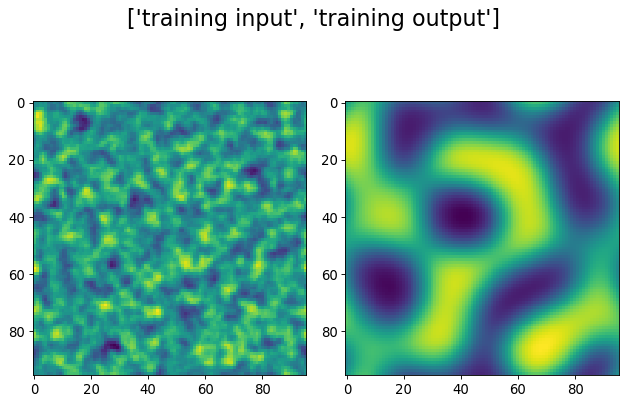

In [26]:
utils.draw_by_side(x_trn[0], y_trn[0], ["training input", "training output"])

In [27]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 8

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 1280
No. of validation steps: 16
No. of prediction steps: 4


In [58]:
# from chnet.unet import UNet
# model = UNet(in_channels=1, 
#              out_channels=1, 
#              init_features=init_features).double().to(device)

# from chnet.unet2d import UNet2D
# model = UNet2D(in_ch=1, 
#                 out_ch=1, 
#                 degree=32).double().to(device)

# from chnet.lstm_unet import Unet_solo
# model = Unet_solo(input_nc=1, output_nc=1, ngf=ngf).double().to(device)

from chnet.lstm_unet import Unet_loop
temporal = 3
ngf = 16
model = Unet_loop(input_nc=1, output_nc=1, ngf=ngf, tanh=True, temporal=temporal).double().to(device)


criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [64]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx=dx, 
                                dt=dt,
                                gamma=gamma, 
                                seed=25213*1921,
                                device = device)

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

CPU times: user 43.8 s, sys: 39.1 s, total: 1min 22s
Wall time: 1min 22s


In [68]:
num_epochs = 20
# Loss and optimizer
for epoch in range(num_epochs):  
    torch.save(model.state_dict(), "unet_model_ch{}_{}_{}.pt".format(ngf, init_steps, delta_sim_steps))
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd, y_prd_ = model(x)
        loss = criterion(y_tru, y_prd)
        for e in range(temporal):
            loss += criterion(y_tru, y_prd_[:,e])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                 num_epochs, 
                                                                                 i+1, 
                                                                                 total_step, 
                                                                                 np.mean(trn_losses[-16:])))
            
torch.save(model.state_dict(), "unet_model_ch{}_{}_{}.pt".format(ngf, init_steps, delta_sim_steps)) 

Epoch [1/20], Step [1/1280], Training Loss: 20.37428222434
Epoch [1/20], Step [513/1280], Training Loss: 20.86579955982
Epoch [1/20], Step [1025/1280], Training Loss: 20.41162055755



Epoch [2/20], Step [1/1280], Training Loss: 19.89014024514
Epoch [2/20], Step [513/1280], Training Loss: 19.70373439091
Epoch [2/20], Step [1025/1280], Training Loss: 19.38668214941



Epoch [3/20], Step [1/1280], Training Loss: 20.08681928419
Epoch [3/20], Step [513/1280], Training Loss: 19.69410709870
Epoch [3/20], Step [1025/1280], Training Loss: 19.25537025091



Epoch [4/20], Step [1/1280], Training Loss: 19.43839780199
Epoch [4/20], Step [513/1280], Training Loss: 19.10734206307
Epoch [4/20], Step [1025/1280], Training Loss: 19.47943558654



Epoch [5/20], Step [1/1280], Training Loss: 18.93320612114
Epoch [5/20], Step [513/1280], Training Loss: 18.57520672162
Epoch [5/20], Step [1025/1280], Training Loss: 18.27952813695



Epoch [6/20], Step [1/1280], Training Loss: 18.46434493192
Epoch [6/20], Step [513/1280], Training Loss: 17.78042569314
Epoch [6/20], Step [1025/1280], Training Loss: 18.79817579649



Epoch [7/20], Step [1/1280], Training Loss: 18.12991337452
Epoch [7/20], Step [513/1280], Training Loss: 17.87874218675
Epoch [7/20], Step [1025/1280], Training Loss: 17.44043415743



Epoch [8/20], Step [1/1280], Training Loss: 17.63045321976
Epoch [8/20], Step [513/1280], Training Loss: 17.34122469816
Epoch [8/20], Step [1025/1280], Training Loss: 18.18063351019



Epoch [9/20], Step [1/1280], Training Loss: 17.57510151687
Epoch [9/20], Step [513/1280], Training Loss: 16.98969142316
Epoch [9/20], Step [1025/1280], Training Loss: 17.22367012691



Epoch [10/20], Step [1/1280], Training Loss: 17.74527029509
Epoch [10/20], Step [513/1280], Training Loss: 16.85995869951
Epoch [10/20], Step [1025/1280], Training Loss: 17.31707721718



Epoch [11/20], Step [1/1280], Training Loss: 17.35217785734
Epoch [11/20], Step [513/1280], Training Loss: 16.37290835630
Epoch [11/20], Step [1025/1280], Training Loss: 16.12312446555



Epoch [12/20], Step [1/1280], Training Loss: 16.81315715310
Epoch [12/20], Step [513/1280], Training Loss: 17.90519304273
Epoch [12/20], Step [1025/1280], Training Loss: 17.19226552864



Epoch [13/20], Step [1/1280], Training Loss: 16.77599409682
Epoch [13/20], Step [513/1280], Training Loss: 16.37905152120
Epoch [13/20], Step [1025/1280], Training Loss: 16.43052336268



Epoch [14/20], Step [1/1280], Training Loss: 16.10880893726
Epoch [14/20], Step [513/1280], Training Loss: 16.45545013833
Epoch [14/20], Step [1025/1280], Training Loss: 16.11699218692



Epoch [15/20], Step [1/1280], Training Loss: 15.46884331912
Epoch [15/20], Step [513/1280], Training Loss: 16.19742253054
Epoch [15/20], Step [1025/1280], Training Loss: 16.84859528925



Epoch [16/20], Step [1/1280], Training Loss: 15.90592838849
Epoch [16/20], Step [513/1280], Training Loss: 15.24068124364
Epoch [16/20], Step [1025/1280], Training Loss: 16.52563659737



Epoch [17/20], Step [1/1280], Training Loss: 15.31897201699
Epoch [17/20], Step [513/1280], Training Loss: 15.02000822312
Epoch [17/20], Step [1025/1280], Training Loss: 15.69648619473



Epoch [18/20], Step [1/1280], Training Loss: 16.09604192108
Epoch [18/20], Step [513/1280], Training Loss: 15.34354821870
Epoch [18/20], Step [1025/1280], Training Loss: 15.84797134112



Epoch [19/20], Step [1/1280], Training Loss: 16.48982853942
Epoch [19/20], Step [513/1280], Training Loss: 15.04160658801
Epoch [19/20], Step [1025/1280], Training Loss: 14.93485812320



Epoch [20/20], Step [1/1280], Training Loss: 16.48772373054
Epoch [20/20], Step [513/1280], Training Loss: 14.91569926611
Epoch [20/20], Step [1025/1280], Training Loss: 15.70723109014



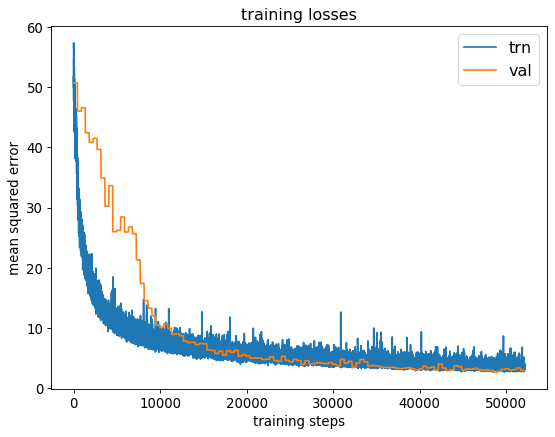

In [69]:
x_t = np.linspace(1, len(trn_losses), len(val_losses))
plt.plot(trn_losses)
plt.plot(x_t, val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

No. of validation steps: 1


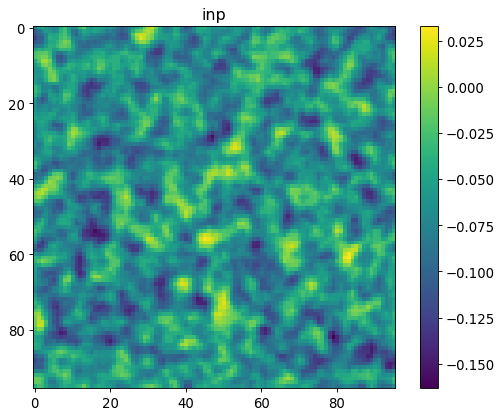

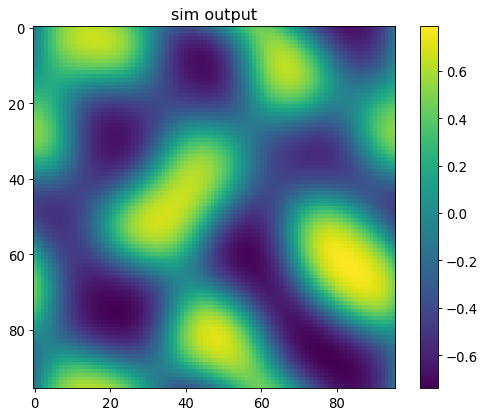

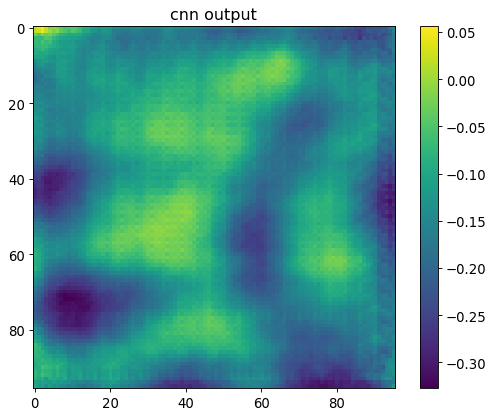

tensor(0.3915, device='cuda:0', dtype=torch.float64)


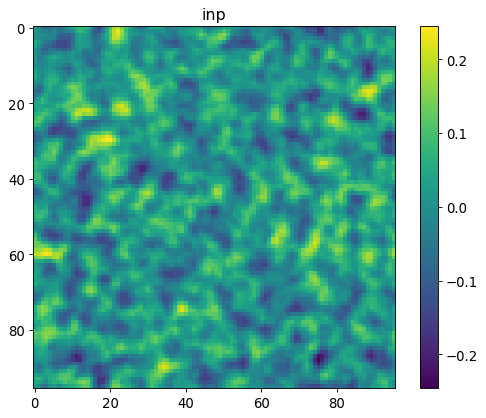

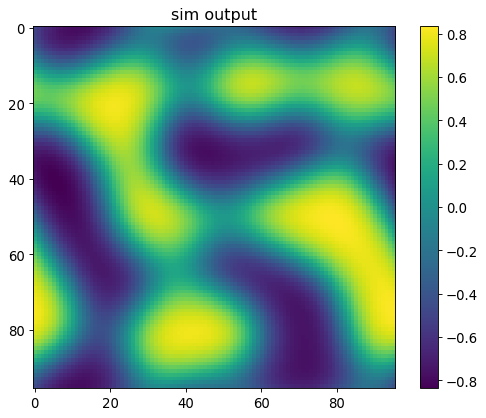

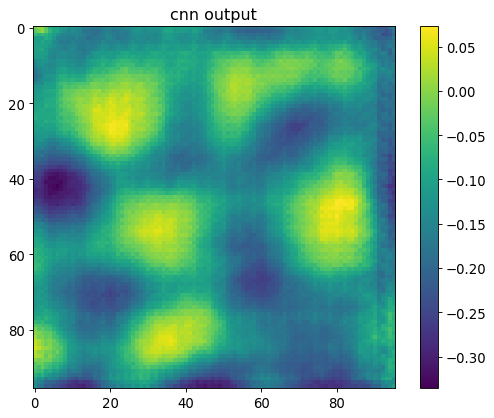

tensor(0.4503, device='cuda:0', dtype=torch.float64)
CPU times: user 2.4 s, sys: 3.8 s, total: 6.2 s
Wall time: 1.53 s


In [74]:
%%time
x_val, y_val = data_generator(nsamples=2, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

prd_losses = []
for item in val_loader:
    model.eval()
    x1 = item['x'].to(device)
    y1 = item['y'].to(device)
    # Forward pass
    y2, _ = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

ix = 0

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2, _ = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")

utils.draw_im(im_y1[0], "sim output")
utils.draw_im(im_y2[0], "cnn output")

print(rmse_loss(y1, y2).data)

ix = 1

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2, _ = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")

utils.draw_im(im_y1[0], "sim output")
utils.draw_im(im_y2[0], "cnn output")

print(rmse_loss(y1, y2).data)